# Overview and Notes

What are interesting scenarios for exploring correlations?
* Expression-dependency correlations for dependency genes that are druggable. For these, the expression correlates are informative for selection of sensitive cell lines/patients. In addition, causally related expression correlates are suggestive of possible resistance mechanisms or secondary targets for a drug combination.
* Dependency-dependency correlations for undruggable genes. For these, the correlates are suggestive of substitute targets, or combinations of targets. However, as combinations are considered the causal interpretation becomes more important.
* Expression-expression correlations. In this case one idea would be to explore the strength and sign of relationships from the data vs. assertions from curated databases/literature, particularly from perturbational experiments.
* Co-expression patterns. Another possibility is to discover patterns of relationships between genes, e.g. that expression of ubiquitin ligases is correlated with the expression of their targets.

Another interesting direction would be to use the information in the INDRA database to discover patterns of mechanistic relationships that predict correlations between dependencies of two genes, or between expression of a gene and dependency of another gene. The simplest possible application of this would be to look at pairwise relationships between two genes (could even extract from SIF), and test to see which types of relationships, and signs of relationships predicted, and amount of evidence predicted a) the sign of a correlation and b) the strength of the correlation.

If the matrix is made complete, i.e., if entries are included for having no known relationship, we may find that having no relationship is not predictive of a lack of a correlation.

Similarly, there will be many mechanistic relationships that yield detectable correlations.

One hypothesis that could be tested is whether downstream siblings were more likely to have large correlations to each other than with their ancestors, highlighting that correlations rarely pick up causal relations in this type of data.

Could do this with graph convolutional nets?

Another application would be to use the data to refine vague relationships extracted from text, or to address issues with assembly, a la distant supervision.

Another direction would be to cluster the correlation graph to find likely intermediates.

Or, to use the redundancy of certain gene families to explain why certain correlations do *not* show up, i.e., the gene knockout has no effect because it has a redundant copy.

# Preliminaries

In [1]:
import pickle
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from indra.databases import hgnc_client
from indra.tools import assemble_corpus as ac

## Load transcript and dependency data and compute correlations


Key variables/functions:
* `ccle_df`. CCLE expression data, DataFrame.
* `crispr_df`. DepMap CRISPR gene effect (dependency) data, DataFrame.
* `crispr_corr`
* `crispr_z`
* `rnai_df`. DepMap combined RNAi data, DataFrame.
* `rna_corr`
* `rnai_z`
* `dep_z`
* `dep_df`. CRISPR and RNAi data combined as averaged z-scores, DataFrame.
* `dep_corr`. Correlation matrix between dep-dep, dep-expr, and expr-expr (though expr-expr correlations are only defined in this matrix for the genes also included in the dependency data).

### Cell line metadata

Load the cell line metadata which includes mappings between cell line identifiers used by different datasets.

In [2]:
cell_line_df = pd.read_csv('data/DepMap-2019q1-celllines_v2.csv')

In [3]:
cell_line_map = cell_line_df[['DepMap_ID', 'CCLE_Name']]
cell_line_map.set_index('CCLE_Name', inplace=True)
cell_line_map.head()

,DepMap_ID
CCLE_Name,
NIHOVCAR3_OVARY,ACH-000001
HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-000002
CACO2_LARGE_INTESTINE,ACH-000003
HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-000004
HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACH-000005


### RNAi data

Load combined RNAi data, normalize column names, map to DepMap cell line IDs, and drop duplicate columns.

In [4]:
%time rnai_df = pd.read_csv('data/D2_combined_gene_dep_scores.csv', index_col=0)
rnai_df = rnai_df.transpose()
gene_cols = ['%s' % col.split(' ')[0] for col in rnai_df.columns]
rnai_df.columns = gene_cols
rnai_df = rnai_df.join(cell_line_map)
rnai_df = rnai_df.set_index('DepMap_ID')
# Drop duplicate columns
rnai_df = rnai_df.loc[:,~rnai_df.columns.duplicated()]

CPU times: user 2.17 s, sys: 112 ms, total: 2.28 s
Wall time: 2.3 s


In [5]:
rnai_df.head()

,A1BG,NAT2,ADA,CDH2,AKT3,MED6,NR2E3,NAALAD2,DUXB,PDZK1P1,...,RCE1,HNRNPDL,DMTF1,PPP4R1,CDH1,SLC12A6,KCNE2,DGCR2,CASP8AP2,SCO2
DepMap_ID,,,,,,,,,,,,,,,,,,,,,
ACH-001270,NaN,NaN,NaN,-0.194962,-0.256108,-0.174220,-0.140052,NaN,NaN,NaN,...,-0.201644,-0.363670,0.184260,-0.115616,-0.125958,NaN,0.088853,NaN,-0.843295,NaN
ACH-001000,NaN,NaN,NaN,-0.028171,0.100751,-0.456124,-0.174618,NaN,NaN,NaN,...,0.074889,0.152158,0.036011,0.117300,0.101725,NaN,-0.110628,NaN,-0.307031,NaN
ACH-001001,0.146042,0.102854,0.168839,0.063047,-0.008077,-0.214376,-0.153619,0.133830,0.138673,0.030345,...,0.006735,-0.033385,0.197651,-0.016372,0.077486,0.106165,0.057286,0.025596,-0.413669,0.122669
ACH-002319,-0.190388,0.384106,-0.120700,-0.237251,0.060267,-0.338946,-0.057551,0.134511,NaN,0.144463,...,0.209009,-0.156839,-0.155837,-0.001141,NaN,0.227968,0.028095,-0.080611,-1.849696,-0.078856
ACH-001827,0.907063,0.403192,0.004394,-0.017059,-0.094749,-0.328074,-0.089573,0.362029,NaN,-0.098161,...,-0.137465,-1.037848,-0.261262,-0.228016,NaN,0.088744,0.159467,0.014071,-0.414154,0.032661


In [6]:
recalculate = False
filename = 'rnai_correlations'
if recalculate:
    %time rnai_corr = rnai_df.corr()
    rnai_corr.to_hdf('%s.h5' % filename, filename)
else:
    rnai_corr = pd.read_hdf('%s.h5' % filename)

In [7]:
rnai_mean = rnai_corr.values.mean()
rnai_sd = rnai_corr.values.std()
rnai_z = (rnai_corr - rnai_mean) / rnai_sd

In [8]:
rnai_z.head()

,A1BG,NAT2,ADA,CDH2,AKT3,MED6,NR2E3,NAALAD2,DUXB,PDZK1P1,...,RCE1,HNRNPDL,DMTF1,PPP4R1,CDH1,SLC12A6,KCNE2,DGCR2,CASP8AP2,SCO2
A1BG,12.735562,-0.770498,-0.828444,0.593730,-0.334519,-0.076705,1.054949,0.591804,0.385034,-0.120219,...,1.446480,-1.964996,-0.403560,0.402625,-0.396057,0.131028,0.227373,-0.701314,0.218191,1.198913
NAT2,-0.770498,12.735562,0.572062,-0.052426,-0.528069,0.307443,-0.021474,-0.590996,-0.318764,-1.449979,...,0.371740,-0.754718,0.017751,0.024919,-2.128375,-0.190518,0.608389,-0.842078,-1.303389,-0.503340
ADA,-0.828444,0.572062,12.735562,-0.451619,-0.577117,0.422290,-0.188984,-0.570248,-0.078767,0.119471,...,0.475397,0.045575,0.639884,0.858577,-0.315503,-0.353140,-0.704099,1.271989,0.150168,-0.217580
CDH2,0.593730,-0.052426,-0.451619,12.735562,0.565031,-0.946426,-0.135411,0.118138,0.201983,-0.383189,...,-0.570892,-1.780034,1.163082,-1.070628,-0.127555,-0.228329,0.010906,-1.423871,-1.132664,-0.382607
AKT3,-0.334519,-0.528069,-0.577117,0.565031,12.735562,-0.378659,-1.136175,0.590426,0.837794,-0.574912,...,-1.262663,0.259384,0.443690,-0.919940,0.283450,-1.192266,-0.581840,-1.243842,-0.184748,-0.345918


### CRISPR Data

Load CRISPR dependency data and normalize column names to gene names.

In [9]:
%time crispr_df = pd.read_csv('data/gene_effect_corrected.csv', index_col=0)
gene_cols = ['%s' % col.split(' ')[0] for col in crispr_df.columns]
crispr_df.columns = gene_cols
# Drop any duplicate columns (shouldn't be any for CRISPR, but just in case)
crispr_df = crispr_df.loc[:,~crispr_df.columns.duplicated()]

CPU times: user 5.44 s, sys: 134 ms, total: 5.58 s
Wall time: 5.6 s


In [10]:
crispr_df.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
ACH-000004,0.134645,0.075536,-0.140209,0.013928,0.029131,-0.147284,0.275829,-0.363633,0.250165,0.129743,...,-0.125018,-0.145802,-0.095429,-0.396903,0.205685,0.197798,-0.347782,0.212048,0.202099,-0.123465
ACH-000005,-0.212445,0.233124,0.044365,0.173837,-0.124389,-0.298849,0.120260,-0.339925,-0.011309,0.015660,...,-0.142212,-0.377179,-0.109019,-0.544686,0.126581,0.033066,-0.060746,0.443834,-0.091548,0.065104
ACH-000007,0.043318,0.066838,-0.036197,0.134781,0.082996,0.119084,0.057116,-0.352541,-0.005800,0.241488,...,-0.063270,-0.469378,-0.068437,-0.207803,0.158380,0.001434,-0.255654,0.065777,-0.314659,-0.358418
ACH-000009,0.070512,0.008430,0.027114,0.055927,0.046325,0.015968,0.053502,-0.498860,0.110794,0.066921,...,0.114418,-0.374999,-0.204950,-0.196839,0.043411,0.018276,-0.398310,0.151885,-0.124333,-0.391758
ACH-000011,0.190935,0.083952,-0.000741,0.353375,-0.037044,-0.205803,0.071275,-0.317310,0.099824,0.105539,...,0.052517,-0.510975,-0.345998,-0.408631,0.241005,0.141594,-0.177939,0.092722,-0.161591,-0.329937


In [255]:
# Filter out this problematic outlier stomach cell line
crispr_df = crispr_df[crispr_df.index != 'ACH-000167']

In [11]:
recalculate = False
filename = 'crispr_correlations'
if recalculate:
    %time crispr_corr = crispr_df.corr()
    crispr_corr.to_hdf('%s.h5' % filename, filename)
else:
    crispr_corr = pd.read_hdf('%s.h5' % filename)    

In [12]:
crispr_mean = crispr_corr.values.mean()
crispr_sd = crispr_corr.values.std()
crispr_z = (crispr_corr - crispr_mean) / crispr_sd

In [13]:
crispr_z.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
A1BG,15.702188,-2.386180,0.707704,-0.934041,-0.379640,1.374084,0.408982,-0.024119,0.247325,-0.840008,...,0.741943,0.435376,1.730729,-0.310362,0.492130,0.223511,-0.891265,0.864840,1.793417,-1.133502
A1CF,-2.386180,15.702188,0.777311,1.014674,-0.416909,-2.654806,1.068659,0.551682,-1.058101,0.509184,...,-0.322839,-0.006776,-0.749077,-0.492167,-0.609961,-0.528955,0.162673,-0.211249,0.596772,1.417246
A2M,0.707704,0.777311,15.702188,2.862549,0.144445,-1.255464,0.221704,0.296796,-0.535641,1.410287,...,-0.024287,-0.161665,-1.115966,-0.854403,0.594724,0.514484,0.636436,-0.222754,0.461710,0.229546
A2ML1,-0.934041,1.014674,2.862549,15.702188,-1.837334,-0.531481,0.075937,-0.393265,-0.517553,-1.381904,...,0.843496,-0.603123,-2.237009,-0.876197,0.254274,0.606953,0.060357,-0.526139,-1.190060,-1.336930
A3GALT2,-0.379640,-0.416909,0.144445,-1.837334,15.702188,-0.823952,-1.520719,-0.882608,0.669479,1.123305,...,0.272494,0.324941,-0.882686,-0.251457,-1.224863,-0.584351,1.820460,0.931479,1.002220,0.874779


### Combine CRISPR and RNAi Z-scores

Take the average of CRISPR and RNAi z-scores and drop missing values (that arise from a gene being knocked down/out in one dataset but not the other).

In [14]:
dep_z = (crispr_z + rnai_z) / 2
dep_z = dep_z.dropna(axis=0, how='all').dropna(axis=1, how='all')

In [15]:
dep_z.head()

,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL2,...,ZSWIM8,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYX,ZZEF1,ZZZ3
A1BG,14.218875,-1.641540,0.174701,-0.710706,0.600630,0.276969,0.241224,-0.499778,-0.270496,0.927183,...,-0.499068,0.087005,0.748763,1.635793,-0.582732,0.101571,0.287507,0.301606,0.782199,-0.821139
A1CF,-1.641540,14.218875,0.226420,1.113856,-1.652816,0.770553,0.806387,-0.226993,0.797251,-0.680314,...,1.401634,-0.206353,0.586287,-1.033367,-0.504007,-0.036164,0.512105,0.481656,-0.142991,0.188393
A2M,0.174701,0.226420,14.218875,0.650837,-1.021248,0.612275,-0.048856,-1.005797,0.025271,-0.062552,...,-1.610764,-0.197283,0.341141,-1.128443,-0.190276,-0.656055,0.235837,-0.123588,0.201963,-0.639490
A2ML1,-0.710706,1.113856,0.650837,14.218875,-0.034970,0.018683,0.300031,0.242733,-0.044408,0.192172,...,-0.950780,0.612281,-0.852989,-1.124449,-0.399207,0.194268,0.216755,-0.629916,-0.978384,-1.194554
A4GALT,0.600630,-1.652816,-1.021248,-0.034970,14.218875,-0.081189,0.682173,-0.223844,0.191413,1.987894,...,-1.212056,0.442917,0.060337,0.259868,-0.439867,0.230350,0.170937,0.713676,-1.218043,-0.387938


### Expression Data

Load the RNA-seq data (in transcripts per million, obtained from the DepMap website at https://depmap.org/portal/download/). Normalize column names (which include both gene names and Ensemble IDs) to only gene names, and then drop duplicate columns, keeping the first instance of the column for the gene name (there are 87 genes associated with more than one Ensemble ID, and these result in duplicate columns after normalizing to gene names).

In [16]:
%time ccle_df = pd.read_csv('data/CCLE_depMap_19Q1_TPM.csv', index_col=0)

CPU times: user 56.2 s, sys: 1.18 s, total: 57.4 s
Wall time: 57.4 s


In [17]:
gene_cols = ['%s' % col.split(' ')[0] for col in ccle_df.columns]
ccle_df.columns = gene_cols
# NOTE: This first way doesn't work! Probably because with duplicate column names a
# separate integer index is created after transposition (?)
#%time ccle_df_drop = ccle_df.T.drop_duplicates(keep='first').T
# See: https://stackoverflow.com/questions/14984119/python-pandas-remove-duplicate-columns
ccle_df_drop = ccle_df.loc[:,~ccle_df.columns.duplicated()]

Filter the expression data to contain only those columns also contained in the CRISPR dependency data (protein coding genes, for the most part).

In [18]:
crispr_cols = [c for c in crispr_df.columns]
# Create a boolean mask to filter the CCLE expression data columns
ccle_col_mask = np.array(ccle_df_drop.columns.map(lambda x: x in crispr_cols), dtype=bool)
ccle_df_filt = ccle_df_drop[ccle_df_drop.columns[ccle_col_mask]]

Join the two datasets on the cell line index:

In [19]:
crispr_expr_join_df = crispr_df.join(ccle_df_filt, how='left', lsuffix=' KO', rsuffix=' RNA')

Calculate the correlations (slow) or reload from HDF5.

In [20]:
recalculate = False
filename = 'dep_expr_correlations'
if recalculate:
    %time corr = dep_expr_join_df.corr()
    corr.to_hdf('%s.h5' % filename, filename)
else:
    corr = pd.read_hdf('%s.h5' % filename)

## Define functions for exploring and visualizing the data

Get the sorted list of correlations for a given gene.

In [21]:
def sort_corrs(corrs, col_name):
    s = corrs[col_name]
    return sorted(list(zip(s.index, s)), key=lambda x: abs(float(x[1])), reverse=True)

Define a function to get the top correlated genes for a given gene.

In [22]:
def get_expr_corrs(df, geneX):
    mygene_arr = df[geneX].values
    data = df.values
    corrs = np.zeros(data.shape[1])
    for i in range(data.shape[1]):
        vect = data[:,i]
        r = np.corrcoef(mygene_arr, vect)[0, 1]
        corrs[i] = r
    genes = [c for c in df.columns]
    corr_genes = sorted(list(zip(genes, corrs)), reverse=True, key=lambda x: abs(x[1]))
    corr_genes_dict = {k: v for k, v in corr_genes}
    return corr_genes

In [62]:
def corrs_for_genes(genes, cutoff=3.0):
    all_corrs = []
    for gene_a in genes:
        try:
            gene_corrs = sort_corrs(dep_z, gene_a)[1:]
        except KeyError:
            continue
        for gene_b, corr_z in gene_corrs:
            if abs(corr_z > cutoff):
                all_corrs.append((gene_a, gene_b, corr_z))
    return all_corrs

Define a function to plot the relationship between the transcription of two genes, along with a linear regression and the residuals.

In [23]:
def scatter(df, geneX, y_arr, y_label, bins=30):
    plt.figure(figsize=(12,3))
    plt.subplot(1, 3, 1)
    plt.plot(df[geneX], y_arr, linestyle='', marker='.')
    plt.xlabel('%s TPM' % geneX)
    plt.ylabel(y_label)
    r = np.corrcoef(df[geneX], y_arr)[0][1]
    plt.title('Corr: %.3f' % r)
    slope, intercept, r_value, p_value, std_err = \
                    stats.linregress(df[geneX], y_arr)
    yhat = slope * df[geneX] + intercept
    plt.plot(df[geneX], yhat, color='k')
    residuals = y_arr - yhat
    plt.subplot(1, 3, 2)
    plt.hist(residuals, bins=bins)
    plt.title('Residuals')
    plt.subplot(1, 3, 3)
    stats.probplot(residuals, dist='norm', plot=plt)
    plt.title('Quantile-quantile plot vs. normal')
    return residuals

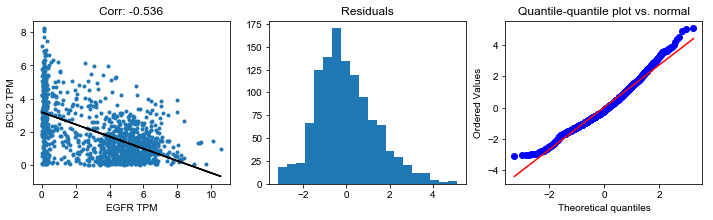

In [24]:
res1 = scatter(ccle_df, 'EGFR', ccle_df['BCL2'], 'BCL2 TPM', bins=20)

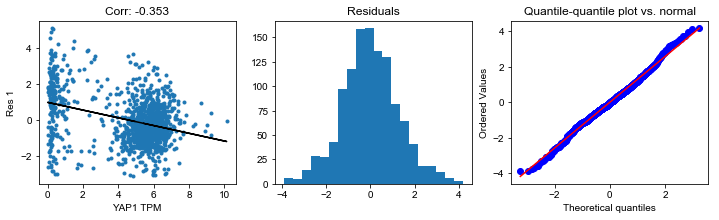

In [25]:
res2 = scatter(ccle_df, 'YAP1', res1, 'Res 1', bins=20)

Next steps:
1. load the INDRA SIF statement file
2. tabulate explanations for correlations;
3. predict correlations from graph structure, edge properties

In [260]:
res = sort_corrs(dep_z, 'BCL2L11')
res

[('BCL2L11', 14.218875270612603),
 ('FAM178B', 4.029245036543984),
 ('SMCO2', 3.791827863043795),
 ('OR5L2', 3.5400642405841536),
 ('PLEKHD1', 3.5344250770722994),
 ('SPINT3', 3.503988607656168),
 ('LYG1', 3.5020203271993),
 ('ORMDL1', 3.4624945302793955),
 ('UBAP1L', 3.3808453783279546),
 ('GLB1L2', 3.378228412025004),
 ('OR1J4', 3.2936097157796476),
 ('MARVELD3', 3.2661221615361695),
 ('FAM171A2', 3.2472549773978043),
 ('ZNF880', 3.2390303829054954),
 ('C14orf37', 3.2271197348712892),
 ('SPG11', 3.221169311039849),
 ('OR7D2', 3.1861995365750326),
 ('BLOC1S2', 3.1718309194195844),
 ('KLLN', 3.166890619793509),
 ('CXCL17', 3.117404161119129),
 ('NUFIP1', 3.1015313865187273),
 ('PPP1R42', 3.1012684154004337),
 ('TMEM30A', 3.0763096555421496),
 ('C15orf61', 3.0674488047734534),
 ('SFTA2', 3.050325164346768),
 ('C6orf52', 2.983253148480228),
 ('ISM2', 2.9721096511632124),
 ('OR52H1', 2.93205284728738),
 ('TMEM233', 2.9186578795668536),
 ('DEPDC1', 2.877741561939793),
 ('RPL9', 2.874825014

In [200]:
for gene, z in res:
    if abs(z) > 1.0:
        print(gene)

SLC39A13
PAMR1
SLC25A23
DYNC2H1
SYT9
MLC1
STX8
SCAMP4
PI15
ACCS
CDC20B
DHH
GPRIN3
SGCB
SLC39A5
HSD17B12
SIT1
FJX1
PPIF
TUSC2
ITPR3
TTC32
AADACL2
OSBPL11
TEF
MPV17L2
PRKCA
SERPINA12
HELB
OXSM
DGCR6L
TRIP4
CSN3
GTPBP3
ZFYVE27
TMEM217
WNT10B
EXOC2
TTLL4
SCNN1G
GTPBP1
COMMD9
CHRM4
CD3G
TGOLN2
URB2
ZNF800
EYA2
RSPRY1
ZNF214
SCRN3
SKOR1
ACTN4
PEX1
EID1
BMP10
LNX1
PTTG1IP
FBN1
KCTD2
CALCB
AFP
TRIM45
BRD8
CCDC50
ISOC2
C9orf40
OR13C3
CYP17A1
EPHB6
PMM1
CD7
RPL3L
LAMC2
AGFG2
KRT12
ALOX15B
MYBPC3
H1FX
NFIX
RASD1
ZNF605
CDC42EP4
ING2
CAMLG
ISOC1
TSPO
SLC25A1
SLC35G2
SIAH3
GALNT14
ZFP64
BTF3L4
TNFRSF10C
INS
BRMS1
BCL2L10
KCNA4
GDF7
KCNH4
KLRC2
RIMKLA
MARCH7
NR2F6
COIL
PRR4
SSBP4
RASSF6
MUS81
CHMP4B
SLC28A3
ARFGAP2
VDR
ARHGAP21
DPF2
TRIM62
TRMT2A
DOK2
TNF
IL17D
MEP1A
PLD3
ZC3H11A
SLC23A2
EGR4
STAB1
DYNLRB2
PTGER3
P2RY1
SLC25A48
ANKRD22
RNF182
ACRV1
ZNF774
GRK7
GPR37
MAPK8IP1
BTBD9
ZNF615
KTN1
EFHC1
SLIT2
NID2
MORC3
CPEB1
COL5A2
DDI1
DENND5A
ABL2
PKIG
TRIM36
FBXW9
ANKFY1
HNMT
PTPRS
ALG12
CRYBB1
FUT1


NRP2
SPATA6
TONSL
FGF12
ADCK2
ADAP1
FOXI2
CHRNA10
DPH5
LILRA2
PSMA8
DUSP28
BCAS3
RAC3
GIPR
ZFP69
OR51T1
THNSL2
MICU2
DEFB118
ZBTB26
DSG3
TRIM44
ZYX
KIF3A
DCUN1D3
RFTN1
GMCL1
KIF5A
KIF2C
NPRL2
GZMH
OR5H15
TKTL2
C6orf48
LRRC14
KMT2C
MBD1
TINF2
GLUD1
SOCS5
CLDN12
RHPN2
EYA4
MMP8
KRTAP10-10
HIST1H3F
RPS7
GLRX3
BID
SLC35D3
KLK12
MRGPRX2
MFSD8
FSIP2
REXO1
CSRP2
ABCG1
SLC50A1
COLGALT2
SCO2
CALN1
FOXF1
CYB5R3
FAM135B
UBE2N
CDK4
OCM2
APOBEC4
HSF2
AHSA2
CORIN
SLC9A8
DYRK4
PID1
OR12D3
DAPK2
DNMT3B
PRSS8
CDH22
AKAP6
ABCA10
BRCA2
PBX1
LGI3
VPS26B
PPM1L
RIMS3
UPK3B
F2
WBP1
PINX1
WDR74
COBL
VPS13C
PEBP1
APOPT1
CPLX4
MMADHC
ISG15
WWC2
HOMER1
PNKP
ORC5
HIST1H4B
CCDC149
ZNF551
NRTN
MAN2B2
RAD51AP1
NRROS
JAG1
RAB8A
NELFE
ARPC5
STT3B
TMEM104
PPP1R3E
ABHD4
FXR2
FOXJ2
ZNF638
ZFHX2
KL
TAAR2
SDR16C5
PAX8
CTR9
SYN3
DSN1
WWP2
REV3L
EDC3
SLC44A4
TTC9C
EXOSC9
RHOB
SLC17A7
WDR5
ALX4
OLFML2B
TMX2
CDH19
HBQ1
CA6
ATG12
CNTN5
FRMPD2
IQCC
HIGD1B
GPR52
ATP4A
KRTAP1-3
CORO1B
WNT7B
AMTN
OR4K17
PTH2R
PLA2G12A
HBM
IQCE
GTSF

## Load Cosmic Data

In [27]:
cos_df = pd.read_csv('data/Census_allThu Jun 13 20_37_30 2019.csv')

In [57]:
cos_df.head()

,Gene Symbol,Name,Entrez GeneId,Genome Location,Tier,Hallmark,Chr Band,Somatic,Germline,Tumour Types(Somatic),Tumour Types(Germline),Cancer Syndrome,Tissue Type,Molecular Genetics,Role in Cancer,Mutation Types,Translocation Partner,Other Germline Mut,Other Syndrome,Synonyms
0,A1CF,APOBEC1 complementation factor,29974,10:50806729-50859940,2,NaN,10q11.23,yes,NaN,melanoma,NaN,NaN,E,NaN,oncogene,Mis,NaN,NaN,NaN,"29974,A1CF,ENSG00000148584,Q9NQ94"
1,ABI1,abl-interactor 1,10006,10:26748570-26860863,1,Yes,10p11.2,yes,NaN,AML,NaN,NaN,L,Dom,"TSG, fusion",T,KMT2A,NaN,NaN,"10006,ABI1,ENSG00000136754,Q8IZP0,SSH3BP1"
2,ABL1,v-abl Abelson murine leukemia viral oncogene h...,25,9:130835447-130885683,1,Yes,9q34.1,yes,NaN,"CML, ALL, T-ALL",NaN,NaN,L,Dom,"oncogene, fusion","T, Mis","BCR, ETV6, NUP214",NaN,NaN,"25,ABL,ABL1,ENSG00000097007,P00519"
3,ABL2,"c-abl oncogene 2, non-receptor tyrosine kinase",27,1:179107718-179143044,1,NaN,1q24-q25,yes,NaN,AML,NaN,NaN,L,Dom,"oncogene, fusion",T,ETV6,NaN,NaN,"27,ABL2,ABLL,ENSG00000143322,P42684"
4,ACKR3,atypical chemokine receptor 3,57007,2:236580466-236581554,1,Yes,2q37.3,yes,NaN,lipoma,NaN,NaN,M,Dom,"oncogene, fusion",T,HMGA2,NaN,NaN,"A8K6J4,ACKR3,CMKOR1,CXCR7,ENSG00000144476,P251..."


In [63]:
cos_corrs = corrs_for_genes(cos_df['Gene Symbol'])

## Load Solute Carrier Family genes

In [139]:
slc_df = pd.read_csv('data/slc_genes.csv')

In [140]:
slc_df.head()
slc_corrs = corrs_for_genes(slc_df['Approved symbol'])

In [141]:
slc_corrs

[('SLC1A6', 'PLA2G6', 3.2063303909715017),
 ('SLC1A7', 'RAB3B', 3.034068487681351),
 ('SLC2A3', 'GOLGA3', 3.2230745514551247),
 ('SLC2A4', 'TNFSF12', 3.4760746645664575),
 ('SLC2A4', 'ALOXE3', 3.1469797324829534),
 ('SLC2A13', 'OTX2', 3.028370290792521),
 ('SLC3A1', 'APOL6', 3.565540352657307),
 ('SLC3A1', 'SIX3', 3.0542282351705534),
 ('SLC3A2', 'SLC7A5', 5.34621135393267),
 ('SLC3A2', 'TRPM7', 3.700587266179051),
 ('SLC4A3', 'CDPF1', 3.1411982482669822),
 ('SLC4A4', 'PKD2L2', 3.469153688972544),
 ('SLC4A4', 'SLIT2', 3.35199534498191),
 ('SLC4A4', 'USP40', 3.1514843432466346),
 ('SLC4A4', 'ZNF571', 3.1055191342234396),
 ('SLC4A7', 'TRPM7', 4.511708609068312),
 ('SLC4A7', 'AHCYL1', 4.239961351823921),
 ('SLC4A7', 'UMPS', 4.191709099416389),
 ('SLC4A7', 'CAD', 4.06762293687536),
 ('SLC4A7', 'ATIC', 3.9071838235802603),
 ('SLC4A7', 'PAICS', 3.838067721140053),
 ('SLC4A7', 'GMPS', 3.768373927049221),
 ('SLC4A7', 'GART', 3.619660407115787),
 ('SLC4A7', 'CTPS1', 3.5948531730443807),
 ('SLC4

In [142]:
import requests

In [187]:
query = {'source': None,
         'target': None,
         'stmt_filter': ['conversion', 'fplx'],
         'node_filter': ['hgnc', 'fplx', 'chebi', 'pubchem', 'go', 'mesh'],
         'node_blacklist': [],
         'edge_hash_blacklist': [],
         'path_length': 1,
         'sign': 'no_sign',
         'weighted': False,
         'bsco': 0.,
         'direct_only': False,
         'curated_db_only': False,         
         'fplx_expand': False,
         'simple': False,
         'k_shortest': False}

def get_expl_corrs(gene_pairs):
    no_path = []
    has_2path = []
    has_3path = []
    for ix, (gene_a, gene_b, z_score) in enumerate(gene_pairs):
        for source, target in ((gene_a, gene_b), (gene_b, gene_a)):
            print("%d getting paths for %s, %s" % (ix, source, target))
            query['source'] = source
            query['target'] = target
            query['path_length'] = 1
            res = requests.post('http://127.0.0.1:5000/query/submit', json=query).json()
            if '2' in res['result']['paths_by_node_count']:
                has_2path.append((source, target, z_score))
            else:
                query['path_length'] = 2
                res = requests.post('http://127.0.0.1:5000/query/submit', json=query).json()
                if '3' in res['result']['paths_by_node_count']:
                    has_3path.append((source, target, z_score))                
                else:
                    no_path.append((source, target, z_score))
    return {'no_path': no_path, 'has_2path': has_2path, 'has_3path': has_3path}

In [188]:
paths = get_expl_corrs(sorted(slc_corrs, key=lambda x: x[2], reverse=True))

0 getting paths for XPR1, KIDINS220
0 getting paths for KIDINS220, XPR1
1 getting paths for SLC26A6, IQCF5
1 getting paths for IQCF5, SLC26A6
2 getting paths for MTCH2, DNAJC11
2 getting paths for DNAJC11, MTCH2
3 getting paths for SLC3A2, SLC7A5
3 getting paths for SLC7A5, SLC3A2
4 getting paths for SLC7A5, SLC3A2
4 getting paths for SLC3A2, SLC7A5
5 getting paths for SLC25A3, CYC1
5 getting paths for CYC1, SLC25A3
6 getting paths for SLC25A3, MRPL21
6 getting paths for MRPL21, SLC25A3
7 getting paths for SLC30A9, GRSF1
7 getting paths for GRSF1, SLC30A9
8 getting paths for SLC25A26, NSUN4
8 getting paths for NSUN4, SLC25A26
9 getting paths for SLC25A26, EARS2
9 getting paths for EARS2, SLC25A26
10 getting paths for SLC35B2, EXTL3
10 getting paths for EXTL3, SLC35B2
11 getting paths for MPDU1, ALG9
11 getting paths for ALG9, MPDU1
12 getting paths for SLC25A26, NARS2
12 getting paths for NARS2, SLC25A26
13 getting paths for SLC25A26, SSBP1
13 getting paths for SSBP1, SLC25A26
14 getti

117 getting paths for SLC25A51, UQCRC2
117 getting paths for UQCRC2, SLC25A51
118 getting paths for SLC25A3, COX5B
118 getting paths for COX5B, SLC25A3
119 getting paths for SLC36A2, OR8D2
119 getting paths for OR8D2, SLC36A2
120 getting paths for SLC25A26, PPA2
120 getting paths for PPA2, SLC25A26
121 getting paths for SLC25A3, ATP5O
121 getting paths for ATP5O, SLC25A3
122 getting paths for SLC30A9, MTRF1L
122 getting paths for MTRF1L, SLC30A9
123 getting paths for SLC30A9, TFAM
123 getting paths for TFAM, SLC30A9
124 getting paths for SLC4A7, CAD
124 getting paths for CAD, SLC4A7
125 getting paths for SLC39A14, FAM171A2
125 getting paths for FAM171A2, SLC39A14
126 getting paths for SLC35B2, B4GALT7
126 getting paths for B4GALT7, SLC35B2
127 getting paths for SLC25A3, NDUFS7
127 getting paths for NDUFS7, SLC25A3
128 getting paths for SLC36A2, GPR137
128 getting paths for GPR137, SLC36A2
129 getting paths for SLC25A26, AARS2
129 getting paths for AARS2, SLC25A26
130 getting paths for 

226 getting paths for SLC15A4, OR8D1
226 getting paths for OR8D1, SLC15A4
227 getting paths for SLC39A13, SYT9
227 getting paths for SYT9, SLC39A13
228 getting paths for SLC4A7, GMPS
228 getting paths for GMPS, SLC4A7
229 getting paths for MPDU1, ALG6
229 getting paths for ALG6, MPDU1
230 getting paths for SLC39A13, MLC1
230 getting paths for MLC1, SLC39A13
231 getting paths for SLC22A25, SP4
231 getting paths for SP4, SLC22A25
232 getting paths for SLC39A14, C5orf47
232 getting paths for C5orf47, SLC39A14
233 getting paths for SLC25A26, MRPS22
233 getting paths for MRPS22, SLC25A26
234 getting paths for SLC25A3, MRPL22
234 getting paths for MRPL22, SLC25A3
235 getting paths for SLC25A26, TRMT10C
235 getting paths for TRMT10C, SLC25A26
236 getting paths for SLC7A9, NCCRP1
236 getting paths for NCCRP1, SLC7A9
237 getting paths for SLC25A3, SCO2
237 getting paths for SCO2, SLC25A3
238 getting paths for SLC7A9, KCNK6
238 getting paths for KCNK6, SLC7A9
239 getting paths for SLC25A26, GTPB

337 getting paths for OR7D2, SLC39A14
338 getting paths for SLC30A9, NDUFS7
338 getting paths for NDUFS7, SLC30A9
339 getting paths for SLC33A1, NFE2L2
339 getting paths for NFE2L2, SLC33A1
340 getting paths for SLC39A13, ACCS
340 getting paths for ACCS, SLC39A13
341 getting paths for SLC25A51, NDUFV2
341 getting paths for NDUFV2, SLC25A51
342 getting paths for SLC25A38, PNPLA8
342 getting paths for PNPLA8, SLC25A38
343 getting paths for SLC25A26, PGS1
343 getting paths for PGS1, SLC25A26
344 getting paths for SLC25A3, NFU1
344 getting paths for NFU1, SLC25A3
345 getting paths for SLC25A3, FASTKD5
345 getting paths for FASTKD5, SLC25A3
346 getting paths for SLC30A9, MRPL40
346 getting paths for MRPL40, SLC30A9
347 getting paths for SLC39A14, VWA5B2
347 getting paths for VWA5B2, SLC39A14
348 getting paths for SLC39A14, OR56B4
348 getting paths for OR56B4, SLC39A14
349 getting paths for SLC35B2, HS2ST1
349 getting paths for HS2ST1, SLC35B2
350 getting paths for SLC4A7, PFAS
350 getting p

451 getting paths for SLC4A7, ADSL
451 getting paths for ADSL, SLC4A7
452 getting paths for MPC1, DLAT
452 getting paths for DLAT, MPC1
453 getting paths for SLC25A10, SLC38A10
453 getting paths for SLC38A10, SLC25A10
454 getting paths for SLC38A10, SLC25A10
454 getting paths for SLC25A10, SLC38A10
455 getting paths for SLC20A1, PPAT
455 getting paths for PPAT, SLC20A1
456 getting paths for SLC25A3, GRSF1
456 getting paths for GRSF1, SLC25A3
457 getting paths for SLC36A2, FAM3D
457 getting paths for FAM3D, SLC36A2
458 getting paths for SLC22A25, PIWIL4
458 getting paths for PIWIL4, SLC22A25
459 getting paths for SLC22A25, HIST1H2BJ
459 getting paths for HIST1H2BJ, SLC22A25
460 getting paths for SLC25A39, MMP21
460 getting paths for MMP21, SLC25A39
461 getting paths for SLC30A9, COX18
461 getting paths for COX18, SLC30A9
462 getting paths for SLC22A25, PADI2
462 getting paths for PADI2, SLC22A25
463 getting paths for SLC39A14, MFSD5
463 getting paths for MFSD5, SLC39A14
464 getting path

568 getting paths for NDUFB8, SLC25A3
569 getting paths for SLC39A14, ANKRD34C
569 getting paths for ANKRD34C, SLC39A14
570 getting paths for SLC36A2, IGFN1
570 getting paths for IGFN1, SLC36A2
571 getting paths for SLC39A1, SOCS3
571 getting paths for SOCS3, SLC39A1
572 getting paths for SLC26A6, PHF7
572 getting paths for PHF7, SLC26A6
573 getting paths for ANKH, AMBRA1
573 getting paths for AMBRA1, ANKH
574 getting paths for SLC25A1, C2orf76
574 getting paths for C2orf76, SLC25A1
575 getting paths for SLC25A51, UQCR10
575 getting paths for UQCR10, SLC25A51
576 getting paths for SLC22A25, PPP1CB
576 getting paths for PPP1CB, SLC22A25
577 getting paths for SLC22A11, UBE2E1
577 getting paths for UBE2E1, SLC22A11
578 getting paths for SLC39A7, RPN1
578 getting paths for RPN1, SLC39A7
579 getting paths for SLC22A11, DTX1
579 getting paths for DTX1, SLC22A11
580 getting paths for SLC22A11, CENPA
580 getting paths for CENPA, SLC22A11
581 getting paths for SLC39A14, SPIRE1
581 getting paths

683 getting paths for SLC6A9, CCR7
683 getting paths for CCR7, SLC6A9
684 getting paths for SLC44A2, FBXW9
684 getting paths for FBXW9, SLC44A2
685 getting paths for SLC39A7, ARPC2
685 getting paths for ARPC2, SLC39A7
686 getting paths for SLC25A23, SYT9
686 getting paths for SYT9, SLC25A23
687 getting paths for SLC39A13, AADACL2
687 getting paths for AADACL2, SLC39A13
688 getting paths for SLC25A18, CCT8L2
688 getting paths for CCT8L2, SLC25A18
689 getting paths for SLC25A26, TFAM
689 getting paths for TFAM, SLC25A26
690 getting paths for SLC15A4, PATE4
690 getting paths for PATE4, SLC15A4
691 getting paths for SLC15A4, TMEM233
691 getting paths for TMEM233, SLC15A4
692 getting paths for SLC22A11, ARRB1
692 getting paths for ARRB1, SLC22A11
693 getting paths for SLC6A12, DHRS12
693 getting paths for DHRS12, SLC6A12
694 getting paths for SLC7A9, C9orf40
694 getting paths for C9orf40, SLC7A9
695 getting paths for SLC1A6, PLA2G6
695 getting paths for PLA2G6, SLC1A6
696 getting paths for 

795 getting paths for SLC30A9, UQCRC1
795 getting paths for UQCRC1, SLC30A9
796 getting paths for SLC35E4, CRYBB2
796 getting paths for CRYBB2, SLC35E4
797 getting paths for SLC25A3, PDSS2
797 getting paths for PDSS2, SLC25A3
798 getting paths for SLC2A4, ALOXE3
798 getting paths for ALOXE3, SLC2A4
799 getting paths for SLC22A8, MBD3L1
799 getting paths for MBD3L1, SLC22A8
800 getting paths for SLC25A3, MRPL2
800 getting paths for MRPL2, SLC25A3
801 getting paths for SLC25A26, MRPS28
801 getting paths for MRPS28, SLC25A26
802 getting paths for SLC22A25, DNAJC2
802 getting paths for DNAJC2, SLC22A25
803 getting paths for SLC15A4, IQCF5
803 getting paths for IQCF5, SLC15A4
804 getting paths for SLC22A11, USP49
804 getting paths for USP49, SLC22A11
805 getting paths for SLC25A26, TIMMDC1
805 getting paths for TIMMDC1, SLC25A26
806 getting paths for SLC30A9, NDUFA6
806 getting paths for NDUFA6, SLC30A9
807 getting paths for SLC15A4, C8orf48
807 getting paths for C8orf48, SLC15A4
808 gettin

907 getting paths for SLC25A51, NDUFS5
907 getting paths for NDUFS5, SLC25A51
908 getting paths for SLC22A11, USP21
908 getting paths for USP21, SLC22A11
909 getting paths for SLC22A12, MRPL11
909 getting paths for MRPL11, SLC22A12
910 getting paths for SLC39A7, DPAGT1
910 getting paths for DPAGT1, SLC39A7
911 getting paths for SLC39A13, DGCR6L
911 getting paths for DGCR6L, SLC39A13
912 getting paths for SLC11A2, ANKRD2
912 getting paths for ANKRD2, SLC11A2
913 getting paths for SLC36A2, FAM178B
913 getting paths for FAM178B, SLC36A2
914 getting paths for SLC25A51, COX11
914 getting paths for COX11, SLC25A51
915 getting paths for SLC39A14, OR10AG1
915 getting paths for OR10AG1, SLC39A14
916 getting paths for SLC22A8, PARP4
916 getting paths for PARP4, SLC22A8
917 getting paths for SLC22A13, PRDM12
917 getting paths for PRDM12, SLC22A13
918 getting paths for SLC25A3, UQCRFS1
918 getting paths for UQCRFS1, SLC25A3
919 getting paths for SLC20A1, STK17B
919 getting paths for STK17B, SLC20A

1021 getting paths for GLYATL3, SLC15A4
1022 getting paths for SLC25A1, NPTN
1022 getting paths for NPTN, SLC25A1
1023 getting paths for SLC22A11, HEY2
1023 getting paths for HEY2, SLC22A11
1024 getting paths for SLC25A36, OR8D2
1024 getting paths for OR8D2, SLC25A36
1025 getting paths for SLC39A13, TTLL4
1025 getting paths for TTLL4, SLC39A13
1026 getting paths for SLC25A3, COX11
1026 getting paths for COX11, SLC25A3
1027 getting paths for SLC22A7, ALDH2
1027 getting paths for ALDH2, SLC22A7
1028 getting paths for SLC7A9, ZNF790
1028 getting paths for ZNF790, SLC7A9
1029 getting paths for SLC1A7, RAB3B
1029 getting paths for RAB3B, SLC1A7
1030 getting paths for SLC15A4, TEX264
1030 getting paths for TEX264, SLC15A4
1031 getting paths for LETM1, MRPL16
1031 getting paths for MRPL16, LETM1
1032 getting paths for SLC20A1, ADSL
1032 getting paths for ADSL, SLC20A1
1033 getting paths for SLC6A1, LHFPL4
1033 getting paths for LHFPL4, SLC6A1
1034 getting paths for SLC47A2, TRIM16L
1034 getti

In [189]:
paths['has_2path']

[('SLC3A2', 'SLC7A5', 5.34621135393267),
 ('SLC7A5', 'SLC3A2', 5.34621135393267),
 ('SLC7A5', 'SLC3A2', 5.34621135393267),
 ('SLC3A2', 'SLC7A5', 5.34621135393267),
 ('SLC39A10', 'SLC39A6', 4.522442334841713),
 ('SLC39A10', 'SLC39A6', 4.522442334841713),
 ('MPC1', 'MPC2', 4.509858097381498),
 ('MPC2', 'MPC1', 4.509858097381498),
 ('MPC2', 'MPC1', 4.509858097381498),
 ('MPC1', 'MPC2', 4.509858097381498),
 ('AHCYL1', 'SLC4A7', 4.239961351823921),
 ('TNFSF12', 'SLC2A4', 3.4760746645664575),
 ('CBLN2', 'SLC22A3', 3.2499954804348015),
 ('SLC25A46', 'DNM1L', 3.233270586752856),
 ('SLC22A8', 'SLC22A12', 3.063505122368374),
 ('SLC22A8', 'SLC22A12', 3.063505122368374)]

In [190]:
paths['has_3path']

[('XPR1', 'KIDINS220', 7.822819031860546),
 ('KIDINS220', 'XPR1', 7.822819031860546),
 ('SLC25A3', 'CYC1', 5.294592400204143),
 ('CYC1', 'SLC25A3', 5.294592400204143),
 ('SSBP1', 'SLC25A26', 5.033912409899774),
 ('SLC25A3', 'UQCRC2', 5.007443954391153),
 ('UQCRC2', 'SLC25A3', 5.007443954391153),
 ('SLC25A3', 'COX4I1', 4.956887043056417),
 ('NDUFA11', 'SLC25A3', 4.938554218744361),
 ('PDHB', 'MPC1', 4.785443816058924),
 ('SLC25A3', 'UQCRB', 4.747041796990482),
 ('UQCRB', 'SLC25A3', 4.747041796990482),
 ('SLC25A3', 'MRPS11', 4.686788025865636),
 ('SLC25A3', 'UQCRC1', 4.6797681558484125),
 ('UQCRC1', 'SLC25A3', 4.6797681558484125),
 ('SLC25A26', 'POLG', 4.624536927442327),
 ('SLC25A3', 'NDUFA8', 4.620369455654357),
 ('SLC25A3', 'MRPS22', 4.598076804039433),
 ('MRPL10', 'SLC25A3', 4.5581939790011745),
 ('SLC25A3', 'MRPS5', 4.5259772454204334),
 ('SLC39A6', 'SLC39A10', 4.522442334841713),
 ('SLC39A6', 'SLC39A10', 4.522442334841713),
 ('SLC4A7', 'TRPM7', 4.511708609068312),
 ('TRPM7', 'SLC4A

In [186]:
paths['no_path']

[('SLC26A6', 'IQCF5', 5.594091219165846),
 ('IQCF5', 'SLC26A6', 5.594091219165846),
 ('MTCH2', 'DNAJC11', 5.432172821452666),
 ('DNAJC11', 'MTCH2', 5.432172821452666),
 ('SLC25A3', 'MRPL21', 5.237211452688611),
 ('MRPL21', 'SLC25A3', 5.237211452688611),
 ('SLC30A9', 'GRSF1', 5.22610812268596),
 ('SLC25A26', 'NSUN4', 5.221506293697038),
 ('NSUN4', 'SLC25A26', 5.221506293697038),
 ('SLC25A26', 'EARS2', 5.170092419421744),
 ('EARS2', 'SLC25A26', 5.170092419421744),
 ('SLC35B2', 'EXTL3', 5.165721036484228),
 ('EXTL3', 'SLC35B2', 5.165721036484228),
 ('MPDU1', 'ALG9', 5.056831909687613),
 ('ALG9', 'MPDU1', 5.056831909687613),
 ('SLC25A26', 'NARS2', 5.037644599218636),
 ('NARS2', 'SLC25A26', 5.037644599218636),
 ('COX4I1', 'SLC25A3', 4.956887043056417),
 ('SLC25A3', 'NDUFA11', 4.938554218744361),
 ('SLC25A26', 'MRPS18B', 4.87012409150968),
 ('MRPS18B', 'SLC25A26', 4.87012409150968),
 ('SLC35B2', 'EXT2', 4.867775661421738),
 ('EXT2', 'SLC35B2', 4.867775661421738),
 ('SLC25A3', 'MRPL40', 4.809

In [162]:
query['source'] = 'GRSF1'
query['target'] = 'SLC30A9'
query['path_length'] = 2
res = requests.post('http://127.0.0.1:5000/query/submit', json=query).json()

In [163]:
res

{'result': {'paths_by_node_count': {'3': [{'stmts': [[{'weight': 0.4307830699386198,
        'stmt_type': 'DecreaseAmount',
        'stmt_hash': '-11612054617179774',
        'evidence_count': 1,
        'evidence': {'reach': 1},
        'curated': False,
        'bs': 0.65,
        'subj': 'GRSF1',
        'obj': 'CHEBI:1'}],
      [{'weight': 0.11653392861550833,
        'stmt_type': 'IncreaseAmount',
        'stmt_hash': '14214768558608446',
        'evidence_count': 1,
        'evidence': {'bel_lc': 1},
        'curated': True,
        'bs': 0.89,
        'subj': 'CHEBI:1',
        'obj': 'SLC30A9'}]],
     'path': ['GRSF1', 'CHEBI:1', 'SLC30A9'],
     'cost': '0.547316732348405738'}]},
  'common_targets': [],
  'common_parents': []}}

# Hypothesis: Stronger Effects -> Stronger Correlations

In [253]:
crispr_mean = crispr_df.abs().mean(axis=0).sort_values()

In [254]:
crispr_z_mean = crispr_z.abs().mean(axis=0)

In [231]:
crispr_mean.RAN

1.8202443867054474

In [232]:
crispr_z_mean.RAN

0.9533717204924684

In [234]:
effect_corr = pd.concat([crispr_mean, crispr_z_mean], axis=1, sort=False)

In [235]:
effect_corr.head()

,0,1
CLDN24,0.046911,0.755613
ADAD1,0.051382,0.730215
HBG1,0.051500,0.807305
COL12A1,0.052999,0.699212
DZIP3,0.053770,0.698987


Text(0, 0.5, 'Avg Corr')

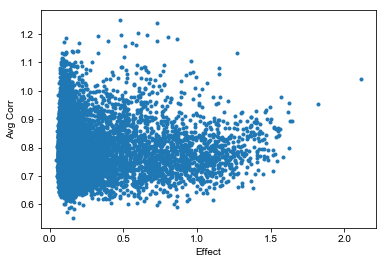

In [239]:
plt.plot(effect_corr[0], effect_corr[1], linestyle='', marker='.')
plt.xlabel('Effect')
plt.ylabel('Avg Corr')

In [248]:
effect_corr[effect_corr[1] > 1.15]

,0,1
PSMA8,0.101370,1.173216
HNRNPA3,0.111467,1.187155
MRPS17,0.201531,1.168656
HNRNPA1L2,0.328600,1.193362
MRPS2,0.394835,1.174895
UBA52,0.475526,1.248301
MRPL3,0.488283,1.196985
MRPL36,0.508941,1.158542
MRPL32,0.558509,1.166765
MRPL35,0.584280,1.160787


# Load INDRA SIF DB

In [ ]:
stmts_df = pd.read_csv('data/stmts_by_pair_type.csv')
# Filter to HGNC only
stmts_df = stmts_df[(stmts_df['agA_ns'] == 'HGNC') & (stmts_df['agB_ns'] == 'HGNC')]
# Remove namespace and identifier columns, leaving only name
stmts_df = stmts_df[['agA_name', 'agB_name', 'stmt_type', 'evidence_count']]
# Remove self-edges
stmts_df = stmts_df[stmts_df['agA_name'] != stmts_df['agB_name']]
# Useful bits of Pandas to know, ultimately not used here:
# pd.crosstab([foo['agA_name'], foo['agB_name']], foo['stmt_type'], foo['evidence_count'],
#             aggfunc='sum', dropna=False).fillna(0)
# baz = bar[bar.apply(lambda x: x.name[0] != x.name[1], axis=1)]

In [ ]:
x_dict = {}
for row in stmts_df.values:
    try:
        raw_corr = dep_z[row[0]][row[1]]
        """
        if int(raw_corr) == 0:
            corr = 0
        elif int(raw_corr) < 0:
            corr = -1
        elif int(raw_corr) > 0:
            corr = 1
        """
        corr = raw_corr
    except KeyError:
        continue
    stmt_type = row[2]
    gene_pair = (row[0], row[1])
    if gene_pair not in x_dict:
        x_dict[gene_pair] = {'Corr': corr}
    x_dict[gene_pair][stmt_type] = row[3]
features = ['Activation', 'Inhibition', 'Corr']
all_data = np.zeros((len(x_dict), len(features)))
for row_ix, feat_dict in enumerate(x_dict.values()):
    for feat_name, feat_val in feat_dict.items():
        if feat_name not in features:
            continue
        feat_ix = features.index(feat_name)
        all_data[row_ix, feat_ix] = feat_val

In [ ]:
"""
# Shuffle the matrix in place
np.random.shuffle(all_data)
# Balance the data
ctr = Counter(all_data[:, -1])
classes = sorted([(k, v) for k,  v in ctr.items()], key=lambda x: x[0])
# Get the class with the fewest members
min_class_count = min([t[1] for t in classes])
min_class_count
data_bal = np.zeros((min_class_count * len(classes), len(features)))
row_ix = 0
for one_class, count in classes:
    num_class_rows = 0
    for ix in range(all_data.shape[0]):
        if all_data[ix, -1] == one_class:
            data_bal[row_ix] = all_data[ix,:]
            row_ix += 1
            num_class_rows += 1
        if num_class_rows >= min_class_count:
            print("Finished class %s, at rows %s" % (one_class, row_ix))
            break

"""

In [ ]:
# Divide training and test
np.random.shuffle(all_data)
partition_ix = int(len(all_data) * 0.8)
train_data = all_data[0:partition_ix, :]
test_data = all_data[partition_ix:, :]
x_train = train_data[:,:-1]
y_train = train_data[:, -1]
x_test = test_data[:, :-1]
y_test = test_data[:, -1]

## Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(x_train, y_train)
nb.score(x_test, y_test)

In [ ]:
yctr = Counter(y_train)
yclasses = sorted([(k, v) for k,  v in yctr.items()], key=lambda x: x[0])

In [ ]:
[features + ['Count']] + list(zip(nb.coef_, classes))

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from sklearn.kernel_ridge import KernelRidge
lr = LinearRegression()

In [ ]:
lr.fit(x_train, y_train)
lr.coef_

In [ ]:
y_pred = lr.predict(x_train)
explained_variance_score(y_train, y_pred)

In [ ]:
y_mean = np.full(y_train.shape, y_train.mean())
explained_variance_score(y_train, y_mean)

In [ ]:
y_pred_test = lr.predict(x_test)
explained_variance_score(y_test, y_pred_test)

# Load INDRA Statements (deprecated)

In [ ]:
reload = False
if reload:
    inc_stmts = ac.load_statements('increase_amt.pkl')
    dec_stmts = ac.load_statements('decrease_amt.pkl')
    stmts = inc_stmts + dec_stmts
    stmts = ac.map_grounding(stmts)
    stmts = [s for s in stmts if s.subj and s.subj.db_refs.get('HGNC')
                             and s.obj and s.obj.db_refs.get('HGNC')]
    stmts = ac.run_preassembly(stmts)
    ac.dump_statements(stmts, 'assembled_stmts.pkl')
else:
    stmts = ac.load_statements('assembled_stmts.pkl')

In [ ]:
stmts_by_obj = defaultdict(list)
for s in stmts:
    gene_id = s.obj.db_refs['HGNC']
    gene_name = hgnc_client.get_hgnc_name(gene_id)
    stmts_by_obj[gene_name].append(s)

In [ ]:
stmt_counts = []
for obj, stmts in stmts_by_obj.items():
    stmt_counts.append((obj, len(stmts)))
stmt_counts.sort(key=lambda x: x[1], reverse=True)

In [ ]:
stmt_counts[0:10]

In [ ]:
gene = 'BCL2'
rank = 0
stmts_by_obj[gene].sort(key=lambda s: s.belief, reverse=True)
print(stmts_by_obj[gene][rank], '\n')
print('\n'.join(['%d: %s\n' % (i, str((e.source_api, e.text)))
                 for i, e in enumerate(stmts_by_obj[gene][rank].evidence)]))